In [1]:
import numpy as np
import pandas as pd
import torch
import os

# !pip3 install wordcloud
# !pip3 install folium
# !pip3 install torchsummaryX
# !pip3 install pycountry
# nltk.download('punkt')
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import pycountry
import folium

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

# splitting the datasets, adding Field and iterating
from sklearn.model_selection import train_test_split
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import nltk
from nltk import word_tokenize
from torchsummaryX import summary


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


from nltk.stem.porter import PorterStemmer

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# change device to cuda: using personal computer's GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

False


In [5]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [6]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [7]:
PATH = '/Users/sancho/Desktop/Spring2021/COMP4211/Project/Project1/'
df = pd.read_csv(PATH + "TheSocialDilemma.csv")
df.head(1)

user_name          user_location  \
0  Mari Smith  San Diego, California   

                                    user_description         user_created  \
0  Premier Facebook Marketing Expert | Social Med...  2007-09-11 22:22:51   

   user_followers  user_friends  user_favourites  user_verified  \
0          579942        288625            11610          False   

                  date                                               text  \
0  2020-09-16 20:55:33  @musicmadmarc @SocialDilemma_ @netflix @Facebo...   

  hashtags           source  is_retweet Sentiment  
0      NaN  Twitter Web App       False   Neutral

In [8]:
text_label = df[["text", "Sentiment"]]

text_label.head(1)

text Sentiment
0  @musicmadmarc @SocialDilemma_ @netflix @Facebo...   Neutral

In [9]:
# preprocessing
def preprocess (text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    
    return text


text_label['text'] = text_label['text'].apply(lambda x: preprocess(x))
text_label['Sentiment'] = text_label['Sentiment'].replace(['Negative','Neutral', 'Positive'],
                                                          [0, 1, 2])

In [10]:
dataCSVdf = pd.DataFrame({"text": text_label["text"], "label": text_label["Sentiment"]})
dataCSVdf.to_csv(os.path.join(PATH, 'preprocessed_data.csv'), index=False) 


In [11]:
df = pd.read_csv(PATH + 'preprocessed_data.csv')

# finding all the empty rows in the dataset
print("Null Rows: ", df["text"].isnull().sum())

# dropping them null rows and resetting the indexes
df = df.dropna()
df = df.reset_index(drop=True)


# looking at all the null rows for further analysis 
nulls = df[df['text'].isnull()].index.tolist()
for i in nulls:
    print('NULL Row Label: ', df['label'][i])

Null Rows:  19


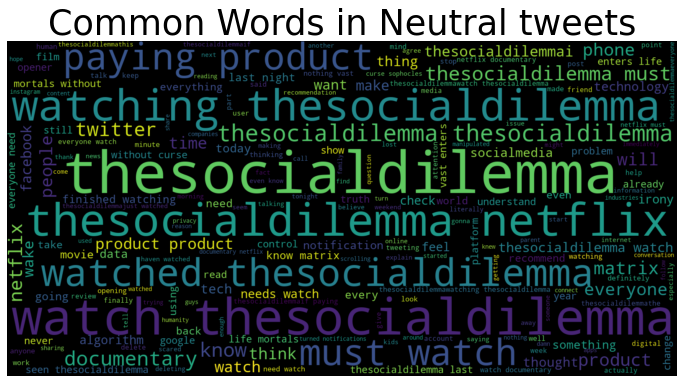

In [12]:
pos_df = text_label[text_label['Sentiment'] == 1]['text'].reset_index()

# Generating Word Clouds
stopwords = set(STOPWORDS)
stopwords.update(["tweet", "please",])
wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Neutral tweets',fontsize=35)
plt.show()

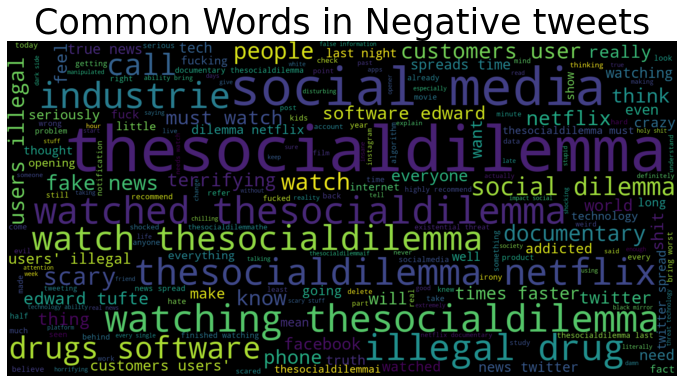

In [13]:
pos_df = text_label[text_label['Sentiment'] == 0]['text'].reset_index()

# Generating Word Clouds
stopwords = set(STOPWORDS)
stopwords.update(["tweet", "please"])
wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Negative tweets',fontsize=35)
plt.show()

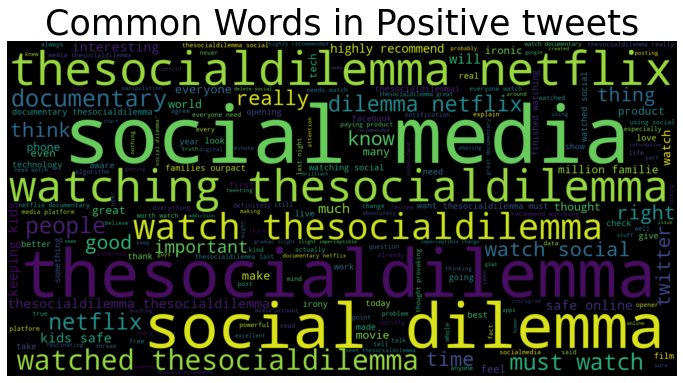

In [14]:
pos_df = text_label[text_label['Sentiment'] == 2]['text'].reset_index()

# Generating Word Clouds
stopwords = set(STOPWORDS)
stopwords.update(["tweet", "please"])
wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Positive tweets',fontsize=35)
plt.show()

In [15]:
# visualizing the labels
neg_size = df["text"].loc[df["label"] == 0].size
neu_size = df["text"].loc[df["label"] == 1].size
pos_size = df["text"].loc[df["label"] == 2].size

print("Negative Sentiments: ", neg_size)
print("Neutral Sentiments: ", neu_size)
print("Positive Sentiments: ", pos_size)
print("All Labels: ", neg_size + neu_size + pos_size)

Negative Sentiments:  3573
Neutral Sentiments:  6963
Positive Sentiments:  9513
All Labels:  20049


In [16]:
fig = plt.figure(figsize = (10, 5))

label_df = df['label'].value_counts().to_frame().reset_index()
label_df.columns = ['label','counts']

fig = px.bar(label_df, x = 'label', y = 'counts', width = 600, height = 400)
fig.show()

<Figure size 720x360 with 0 Axes>

In [17]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
                                    df["text"].loc[df["label"] == 0], 
                                    df["label"].loc[df["label"] == 0], 
                                    train_size=0.626, random_state=4211)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
                                    df["text"].loc[df["label"] == 1], 
                                    df["label"].loc[df["label"] == 1], 
                                    train_size=0.8085, random_state=4211)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
                                    df["text"].loc[df["label"] == 2], 
                                    df["label"].loc[df["label"] == 2], 
                                    train_size=0.8595, random_state=4211)


In [18]:
X_test = pd.concat([X_test_0, X_test_1, X_test_2])
X_train = pd.concat([X_train_0, X_train_1, X_train_2])
y_test = pd.concat([y_test_0, y_test_1, y_test_2])
y_train = pd.concat([y_train_0, y_train_1, y_train_2])

In [19]:
X_test.size, y_test.size, X_train.size, y_train.size

(4008, 4008, 16041, 16041)

In [20]:
# storing dataframes in 2 seperate csv files
X_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

trainCSVdf = pd.DataFrame({"text": X_train["text"], "label": y_train["label"]})
testCSVdf = pd.DataFrame({"text": X_test["text"], "label": y_test["label"]})

#saving the newly split train and validation dataframes to csv files for tabular dataset
trainCSVdf.to_csv(os.path.join(PATH, 'train.csv'), index=False) 
testCSVdf.to_csv(os.path.join(PATH, 'test.csv'), index=False)

In [21]:
# extraction of features using 3 different methods
def extract_features(field, training_data, testing_data, type="binary"):
    
    # Representation with binary features
    if "binary" in type:
        
        cv = CountVectorizer(binary = True, max_df = 0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    # Representation with count based features
    elif "counts" in type:
        
        cv= CountVectorizer(binary = False, max_df = 0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    # Representation with TF-IDF based features
    else:    
        
        tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_df = 0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set = tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set = tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

In [22]:
train_df = pd.read_csv(PATH + "train.csv")
test_df = pd.read_csv(PATH + "test.csv")

In [23]:
# storing the 3 different feature extracted from extract_features
X_train_binary, X_test_binary, feature_transformer_binary = extract_features("text", train_df, test_df, "binary")
X_train_counts, X_test_counts, feature_transformer_counts = extract_features("text", train_df, test_df, "counts")
X_train_tf, X_test_tf, feature_transformer_tf = extract_features("text", train_df, test_df, "tf-idf")

In [24]:
# logistics regression model 1
Baseline_Logistics_Model = LogisticRegression(verbose = 1, solver = 'liblinear', random_state = 4211, C = 2, 
                                    penalty = 'l2', max_iter = 1000)

# feature extractor binary
model_binary = Baseline_Logistics_Model.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Baseline_Logistics_Model.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Baseline_Logistics_Model.fit(X_train_tf, y_train.values.ravel())

[LibLinear][LibLinear][LibLinear]

In [25]:
# different feature model accuracies
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

Binary train score:  0.7389190200112212
Binary test score:  0.6354790419161677

Counts train score:  0.7434698584876255
Counts test score:  0.6392215568862275

TF-IDF train score:  0.9278723271616482
TF-IDF test score:  0.8043912175648703


In [26]:
Logistics_Model_1 = LogisticRegression(verbose = 1, solver = 'lbfgs', random_state = 4211, C = 5, 
                                    penalty = 'l2', max_iter = 2000)

# feature extractor binary
model_binary = Logistics_Model_1.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Logistics_Model_1.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Logistics_Model_1.fit(X_train_tf, y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


In [27]:
# different feature model accuracies
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

Binary train score:  0.785237828065582
Binary test score:  0.6783932135728543

Counts train score:  0.7863599526214077
Counts test score:  0.6793912175648703

TF-IDF train score:  0.9785549529331089
TF-IDF test score:  0.8465568862275449


In [28]:
Logistics_Model_2 = LogisticRegression(verbose = 1, solver = 'sag', random_state = 4211, C = 10, 
                                    penalty = 'l2', max_iter = 2000)

# feature extractor binary
model_binary = Logistics_Model_2.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Logistics_Model_2.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Logistics_Model_2.fit(X_train_tf, y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 274 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 494 epochs took 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [29]:
# different feature model accuracies
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

Binary train score:  0.8019450158967646
Binary test score:  0.6933632734530938

Counts train score:  0.802443737921576
Counts test score:  0.6923652694610778

TF-IDF train score:  0.9903372607692787
TF-IDF test score:  0.8525449101796407


In [30]:
Logistics_Model_3 = LogisticRegression(verbose = 1, solver = 'saga', random_state = 4211, C = 10, 
                                    penalty = 'l2', max_iter = 2000)

# feature extractor binary
model_binary = Logistics_Model_3.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Logistics_Model_3.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Logistics_Model_3.fit(X_train_tf, y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 446 epochs took 8 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 639 epochs took 6 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 58 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [31]:
# different feature model accuracies
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

Binary train score:  0.800261829063026
Binary test score:  0.6903692614770459

Counts train score:  0.8010099121002431
Counts test score:  0.6906187624750499

TF-IDF train score:  0.9903996010223801
TF-IDF test score:  0.8522954091816367


In [32]:
Logistics_Model_4 = LogisticRegression(verbose = 1, solver = 'liblinear', random_state = 4211, C = 10, 
                                    penalty = 'l2', max_iter = 2000)

# feature extractor binary
model_binary = Logistics_Model_4.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Logistics_Model_4.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Logistics_Model_4.fit(X_train_tf, y_train.values.ravel())

[LibLinear][LibLinear][LibLinear]

In [33]:
# different feature model accuracies
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

Binary train score:  0.7925939779315504
Binary test score:  0.6841317365269461

Counts train score:  0.7935290817280718
Counts test score:  0.6858782435129741

TF-IDF train score:  0.9793653762234275
TF-IDF test score:  0.8530439121756487


In [34]:
def feature_extractor (vocab_size, X_train, X_test, max_length):
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='pre', truncating='pre')
    test_sequences = tokenizer.texts_to_sequences(X_test)
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='pre', truncating='pre')

    print("Shape of train_padded:", train_padded.shape)
    print("Shape of test_padded:", test_padded.shape)
    
    return train_padded, test_padded

In [35]:
def Model_Config(model_type, vocab_size, embedding_dim, max_length, hidden_layers,
                 activation_func_1, activation_func_2, dropout_rate, regularization_factor, num_epochs,
                 X_train, X_test):
        
    # GRU Model
    if model_type == 'GRU':
        model = Sequential([
                    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                    tf.keras.layers.GRU(hidden_layers),
                    tf.keras.layers.Dense(max_length/2, 
                    activation = activation_func_1, kernel_regularizer = tf.keras.regularizers.l2(regularization_factor)),
                    tf.keras.layers.Dropout(dropout_rate), 
                    tf.keras.layers.Dense(3, activation = activation_func_2)
                    ])
    # LSTM Model
    elif model_type == 'LSTM':
        model = Sequential([
                    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                    tf.keras.layers.LSTM(hidden_layers),
                    tf.keras.layers.Dense(max_length/2, 
                    activation = activation_func_1, kernel_regularizer = tf.keras.regularizers.l2(regularization_factor)),
                    tf.keras.layers.Dropout(dropout_rate), 
                    tf.keras.layers.Dense(3, activation = activation_func_2)
                    ])
    
    model.summary()
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                0.01, decay_steps = 10000, decay_rate = 0.95, staircase = True)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
                 loss='sparse_categorical_crossentropy', metrics = ['accuracy', 'MeanSquaredError'])

    model_holder = model.fit(X_train, y_train, epochs = num_epochs, validation_data = (X_test, y_test))
    
    return model_holder

In [36]:
X_train = train_df["text"]
X_test = test_df["text"]

In [37]:
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float) 

train, test = TabularDataset.splits(path=PATH, train='train.csv', test = 'test.csv',
                                           format='csv', fields=[('sentence', txt_field), 
                                           ('label', label_field)], skip_header=True)

# build the vocabulary with freq 2
txt_field.build_vocab(X_train, min_freq=1)
lengthFreqTrain1 = len(txt_field.vocab)
txt_field.build_vocab(X_train, min_freq=2)
lengthFreqTrain2 = len(txt_field.vocab)

oov_total_train = lengthFreqTrain1 - lengthFreqTrain2

txt_field.build_vocab(X_test, min_freq=1)
lengthFreqValid1 = len(txt_field.vocab)
txt_field.build_vocab(X_test, min_freq=2)
lengthFreqValid2 = len(txt_field.vocab)

oov_total_valid = lengthFreqValid1 - lengthFreqValid2

print("oov_total_train: ", oov_total_train)
print("oov_total_valid: ", oov_total_valid)
print("Total vocab length: ", lengthFreqTrain1)

oov_total_train:  91
oov_total_valid:  80
Total vocab length:  287


In [38]:
vocab_size = 8000
embedding_dim = 32
max_length = 90
hidden_layers = 64
activation_func_1 = 'sigmoid'
activation_func_2 = 'softmax'
dropout_rate = 0.4
regularization_factor = 0.001
num_epochs = 10

In [39]:
X_train, X_test = feature_extractor (vocab_size, X_train, X_test, max_length)

Shape of train_padded: (16041, 90)
Shape of test_padded: (4008, 90)


In [40]:
GRU_Model = Model_Config('GRU', vocab_size, embedding_dim, max_length, hidden_layers,
                 activation_func_1, activation_func_2, dropout_rate, regularization_factor, num_epochs, X_train, X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 32)            256000    
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 45)                2925      
_________________________________________________________________
dropout (Dropout)            (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 138       
Total params: 277,879
Trainable params: 277,879
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
502/502 [==============================] - 32s 57ms/step - loss: 0.7276 - accuracy: 0.7112 - mean_squared

In [41]:
LSTM_Model = Model_Config('LSTM', vocab_size, embedding_dim, max_length, hidden_layers,
                 activation_func_1, activation_func_2, dropout_rate, regularization_factor, num_epochs, X_train, X_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 32)            256000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2925      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 138       
Total params: 283,895
Trainable params: 283,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
502/502 [==============================] - 28s 53ms/step - loss: 0.8176 - accuracy: 0.6707 - mean_squar

In [42]:
def basic_models (model_type, X_train, X_test, y_train, y_test):
    if model_type == 'XGB':
        model = XGBClassifier(use_label_encoder=False)
    
    elif model_type == 'DecisionTree':
        model = DecisionTreeClassifier(max_depth=20, criterion="entropy", max_features="auto", random_state=4211)
        
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(max_depth=20, criterion="entropy", max_features="log2", random_state=4211)
    
    elif model_type == 'SupportMachineVector':
        model = SVC(kernel='rbf', verbose=True, C=5, random_state=4211)
        
    model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)
    
    # confusion matrix
    plot_confusion_matrix(model, X_test, y_test.values.ravel())

    print("Training Accuracy [{}]: ".format(model_type), model.score(X_train, y_train.values.ravel()))
    print("Validation Accuracy [{}]:".format(model_type), model.score(X_test, y_test.values.ravel()))

    # calculating the f1 score for the validation set
    print("f1 score [{}]:".format(model_type), f1_score(y_test, y_pred, average='weighted'))

    return model.score(X_train, y_train.values.ravel()), model.score(X_test, y_test.values.ravel())

[23:02:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy [XGB]:  0.8443363880057353
Validation Accuracy [XGB]: 0.500998003992016
f1 score [XGB]: 0.462035607814459


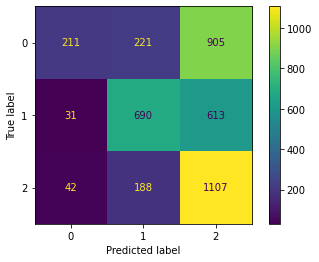

In [43]:
XGB_train_acc, XGB_test_acc = basic_models('XGB', X_train, X_test, y_train, y_test)

Training Accuracy [DecisionTree]:  0.7929680194501589
Validation Accuracy [DecisionTree]: 0.43812375249500995
f1 score [DecisionTree]: 0.3864503843957456


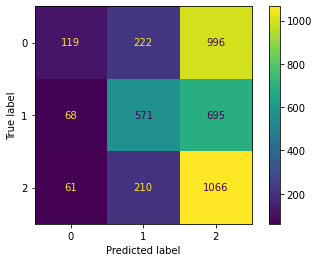

In [44]:
Dec_train_acc, Dec_test_acc = basic_models('DecisionTree', X_train, X_test, y_train, y_test)

Training Accuracy [RandomForest]:  0.8297487687800013
Validation Accuracy [RandomForest]: 0.4720558882235529
f1 score [RandomForest]: 0.42105434415402987


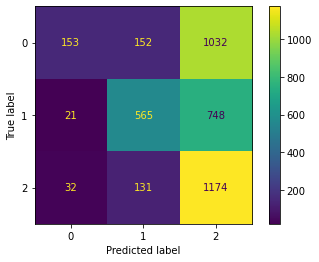

In [45]:
RFT_train_acc, RFT_test_acc = basic_models('RandomForest', X_train, X_test, y_train, y_test)

[LibSVM]Training Accuracy [SupportMachineVector]:  0.6722772894457951
Validation Accuracy [SupportMachineVector]: 0.40993013972055886
f1 score [SupportMachineVector]: 0.35060682959754946


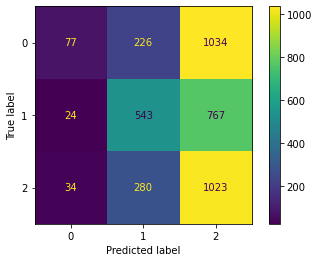

In [46]:
SVM_train_acc, SVM_test_acc = basic_models('SupportMachineVector', X_train, X_test, y_train, y_test)

In [47]:
# remove "thesocialdilemma" and other features to the text dataset such as source

In [48]:
entire_df = pd.read_csv(PATH + "TheSocialDilemma.csv")

In [49]:
df_source = entire_df["source"]

entire_df["user_location"].replace(np.nan, " ", inplace = True)
entire_df["text_source"] = entire_df["source"] + " " + entire_df["text"] + " " + entire_df["user_location"]
entire_df["user_verified"].replace(True, "verified", inplace=True)
entire_df["user_verified"].replace(False, "refute", inplace=True)

entire_df["text_source"] = entire_df["text_source"] + " " + entire_df["user_verified"]

In [50]:
# preprocessing

from nltk.corpus import stopwords
def preprocess_2 (text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    

    # lemmetization/stemming
    stop_words = stopwords.words('english')
    stop_words.extend(["#thesocialdilemma", "thesocialdilemma", "twitter", "for"])

    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    
    sentence = ' '.join(tokens_without_sw)
    return sentence


entire_df['text_source'] = entire_df['text_source'].apply(lambda x: preprocess_2(x))
entire_df['Sentiment'] = text_label['Sentiment'].replace(['Negative','Neutral', 'Positive'],
                                                          [0, 1, 2])

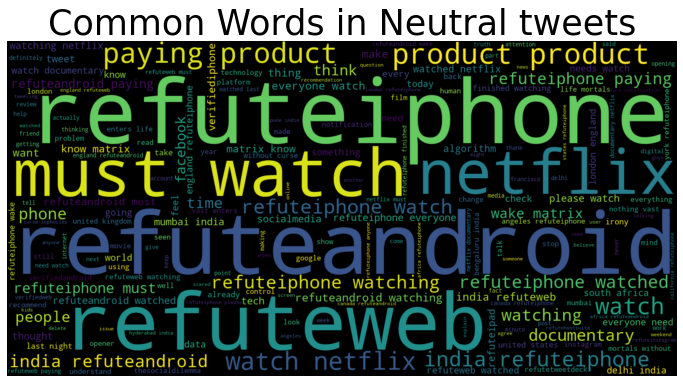

In [51]:
pos_df = entire_df[entire_df['Sentiment'] == 1]['text_source'].reset_index()

stopwords = set(STOPWORDS)

wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text_source']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Neutral tweets',fontsize=35)
plt.show()

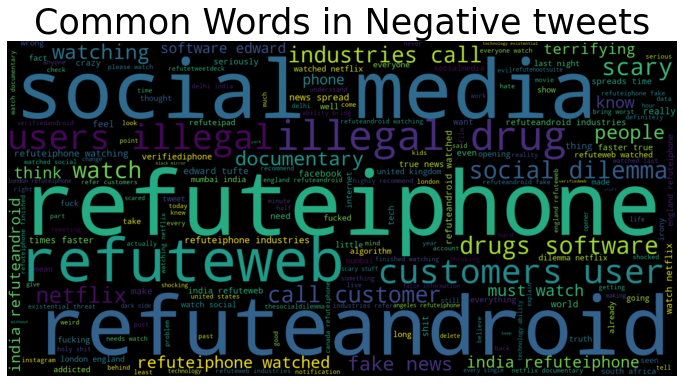

In [52]:
pos_df = entire_df[entire_df['Sentiment'] == 0]['text_source'].reset_index()

stopwords = set(STOPWORDS)

wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text_source']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Negative tweets',fontsize=35)
plt.show()

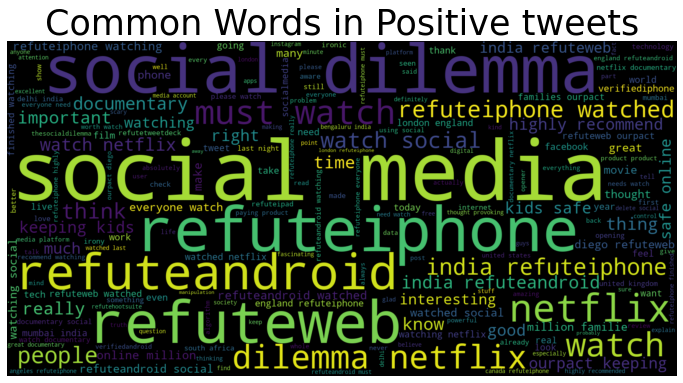

In [53]:
pos_df = entire_df[entire_df['Sentiment'] == 2]['text_source'].reset_index()


stopwords = set(STOPWORDS)
wc = WordCloud(width=1600, height=800, min_word_length=4, 
               stopwords= stopwords, max_words=200).generate("".join(pos_df['text_source']) )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Common Words in Positive tweets',fontsize=35)
plt.show()

In [54]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
                                    entire_df["text_source"].loc[entire_df["Sentiment"] == 0], 
                                    entire_df["Sentiment"].loc[entire_df["Sentiment"] == 0], 
                                    train_size=0.626, random_state=4211)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
                                    entire_df["text_source"].loc[entire_df["Sentiment"] == 1], 
                                    entire_df["Sentiment"].loc[entire_df["Sentiment"] == 1], 
                                    train_size=0.8085, random_state=4211)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
                                    entire_df["text_source"].loc[entire_df["Sentiment"] == 2], 
                                    entire_df["Sentiment"].loc[entire_df["Sentiment"] == 2], 
                                    train_size=0.8595, random_state=4211)


X_test = pd.concat([X_test_0, X_test_1, X_test_2])
X_train = pd.concat([X_train_0, X_train_1, X_train_2])
y_test = pd.concat([y_test_0, y_test_1, y_test_2])
y_train = pd.concat([y_train_0, y_train_1, y_train_2])


# storing dataframes in 2 seperate csv files
X_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

trainCSVdf = pd.DataFrame({"text": X_train["text_source"], "label": y_train["Sentiment"]})
testCSVdf = pd.DataFrame({"text": X_test["text_source"], "label": y_test["Sentiment"]})

#saving the newly split train and validation dataframes to csv files for tabular dataset
trainCSVdf.to_csv(os.path.join(PATH, 'train1.csv'), index=False) 
testCSVdf.to_csv(os.path.join(PATH, 'test1.csv'), index=False)

train_df = pd.read_csv(PATH + "train1.csv")
test_df = pd.read_csv(PATH + "test1.csv")

In [55]:
# storing the 3 different feature extracted from extract_features
X_train_binary, X_test_binary, feature_transformer_binary = extract_features("text", train_df, test_df, "binary")
X_train_counts, X_test_counts, feature_transformer_counts = extract_features("text", train_df, test_df, "counts")
X_train_tf, X_test_tf, feature_transformer_tf = extract_features("text", train_df, test_df, "tf-idf")

In [56]:
# different feature model accuracies
Logistics_Model_4 = LogisticRegression(verbose = 1, solver = 'liblinear', random_state = 4211, C = 10, 
                                    penalty = 'l2', max_iter = 2000)

# feature extractor binary
model_binary = Logistics_Model_4.fit(X_train_binary, y_train.values.ravel())

# feature extractor counts
model_counts = Logistics_Model_4.fit(X_train_counts, y_train.values.ravel())

# feature extractor tf
model_tf = Logistics_Model_4.fit(X_train_tf, y_train.values.ravel())
print("Binary train score: ", model_binary.score(X_train_binary, y_train.values.ravel()))
print("Binary test score: ", model_binary.score(X_test_binary, y_test.values.ravel()))
print()

print("Counts train score: ", model_counts.score(X_train_counts, y_train.values.ravel()))
print("Counts test score: ", model_counts.score(X_test_counts, y_test.values.ravel()))
print()

print("TF-IDF train score: ", model_tf.score(X_train_tf, y_train.values.ravel()))
print("TF-IDF test score: ", model_tf.score(X_test_tf, y_test.values.ravel()))

[LibLinear][LibLinear][LibLinear]Binary train score:  0.7763452914798207
Binary test score:  0.651296111665005

Counts train score:  0.7775909317389138
Counts test score:  0.6557826520438684

TF-IDF train score:  0.9773916292974589
TF-IDF test score:  0.8033399800598205


In [57]:
vocab_size = 9000
embedding_dim = 32
max_length = 120
hidden_layers = 64
activation_func_1 = 'sigmoid'
activation_func_2 = 'softmax'
dropout_rate = 0.4
regularization_factor = 0.001
num_epochs = 5

In [58]:
X_train = train_df["text"]
X_test = test_df["text"]
X_train, X_test = feature_extractor (vocab_size, X_train, X_test, max_length)

Shape of train_padded: (16056, 120)
Shape of test_padded: (4012, 120)


In [59]:
LSTM_Model_1 = Model_Config('LSTM', vocab_size, embedding_dim, max_length, hidden_layers,
                 activation_func_1, activation_func_2, dropout_rate, regularization_factor, num_epochs, X_train, X_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 32)           288000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3900      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 183       
Total params: 316,915
Trainable params: 316,915
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
502/502 [==============================] - 27s 50ms/step - loss: 0.8548 - accuracy: 0.6316 - mean_square

In [60]:
GRU_Model_1 = Model_Config('GRU', vocab_size, embedding_dim, max_length, hidden_layers,
                 activation_func_1, activation_func_2, dropout_rate, regularization_factor, num_epochs, X_train, X_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 32)           288000    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_6 (Dense)              (None, 60)                3900      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 183       
Total params: 310,899
Trainable params: 310,899
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
502/502 [==============================] - 31s 58ms/step - loss: 0.7785 - accuracy: 0.6832 - mean_square

[23:10:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy [XGB]:  0.8494020926756353
Validation Accuracy [XGB]: 0.5271684945164506
f1 score [XGB]: 0.489617159432863


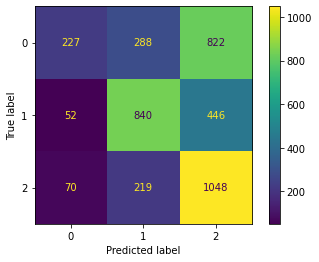

In [61]:
XGB_train_acc_1, XGB_test_acc_1 = basic_models('XGB', X_train, X_test, y_train, y_test)

Training Accuracy [DecisionTree]:  0.7391629297458894
Validation Accuracy [DecisionTree]: 0.44666001994017945
f1 score [DecisionTree]: 0.4029926218513446


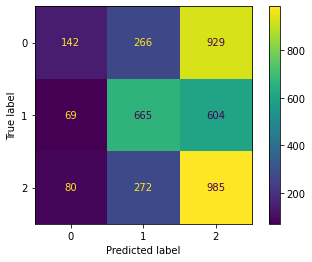

In [62]:
Dec_train_acc_1, Dec_test_acc_1 = basic_models('DecisionTree', X_train, X_test, y_train, y_test)

Training Accuracy [RandomForest]:  0.817887394120578
Validation Accuracy [RandomForest]: 0.48205383848454636
f1 score [RandomForest]: 0.4224745492519355


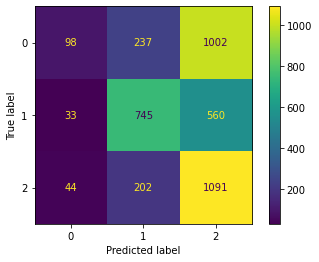

In [63]:
RFT_train_acc_1, RFT_test_acc_1 = basic_models('RandomForest', X_train, X_test, y_train, y_test)

[LibSVM]Training Accuracy [SupportMachineVector]:  0.6484803188839063
Validation Accuracy [SupportMachineVector]: 0.41849451645064806
f1 score [SupportMachineVector]: 0.3601578114020764


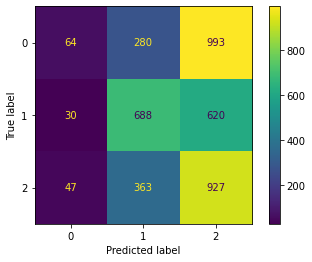

In [64]:
SVM_train_acc_1, SVM_test_acc_1 = basic_models('SupportMachineVector', X_train, X_test, y_train, y_test)

In [65]:
# plotting and visualizing the stats for different models

In [66]:
def plot (model1, model2, model3, model4):
    x1, x2, x3, x4 = model1.history['accuracy'], model2.history['accuracy'], model3.history['accuracy'], model4.history['accuracy']
    steps = np.arange(1, 12)
    plt.plot(x1, label = 'LTSM Model 1')
    plt.plot(x4, label = 'GRU Model 2')
    
    steps = np.arange(1, 12)
    plt.plot(x3, label = 'GRU Model 1')
    plt.plot(x2, label = 'LSTM Model 2')

    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams["figure.dpi"] = 200
    plt.show()

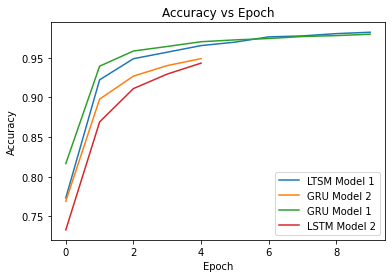

In [67]:
plot(LSTM_Model, LSTM_Model_1, GRU_Model, GRU_Model_1)

In [68]:
best_train_acc_mo = []
best_valid_acc_mo = []

best_train_acc_mo.append(XGB_train_acc)
best_valid_acc_mo.append(XGB_test_acc)
best_train_acc_mo.append(Dec_train_acc)
best_valid_acc_mo.append(Dec_test_acc)
best_train_acc_mo.append(SVM_train_acc)
best_valid_acc_mo.append(SVM_test_acc)
best_train_acc_mo.append(RFT_train_acc)
best_valid_acc_mo.append(RFT_test_acc)
best_train_acc_mo.append(XGB_train_acc_1)
best_valid_acc_mo.append(XGB_test_acc_1)
best_train_acc_mo.append(Dec_train_acc_1)
best_valid_acc_mo.append(Dec_test_acc_1)
best_train_acc_mo.append(SVM_train_acc_1)
best_valid_acc_mo.append(SVM_test_acc_1)
best_train_acc_mo.append(RFT_train_acc_1)
best_valid_acc_mo.append(RFT_test_acc_1)

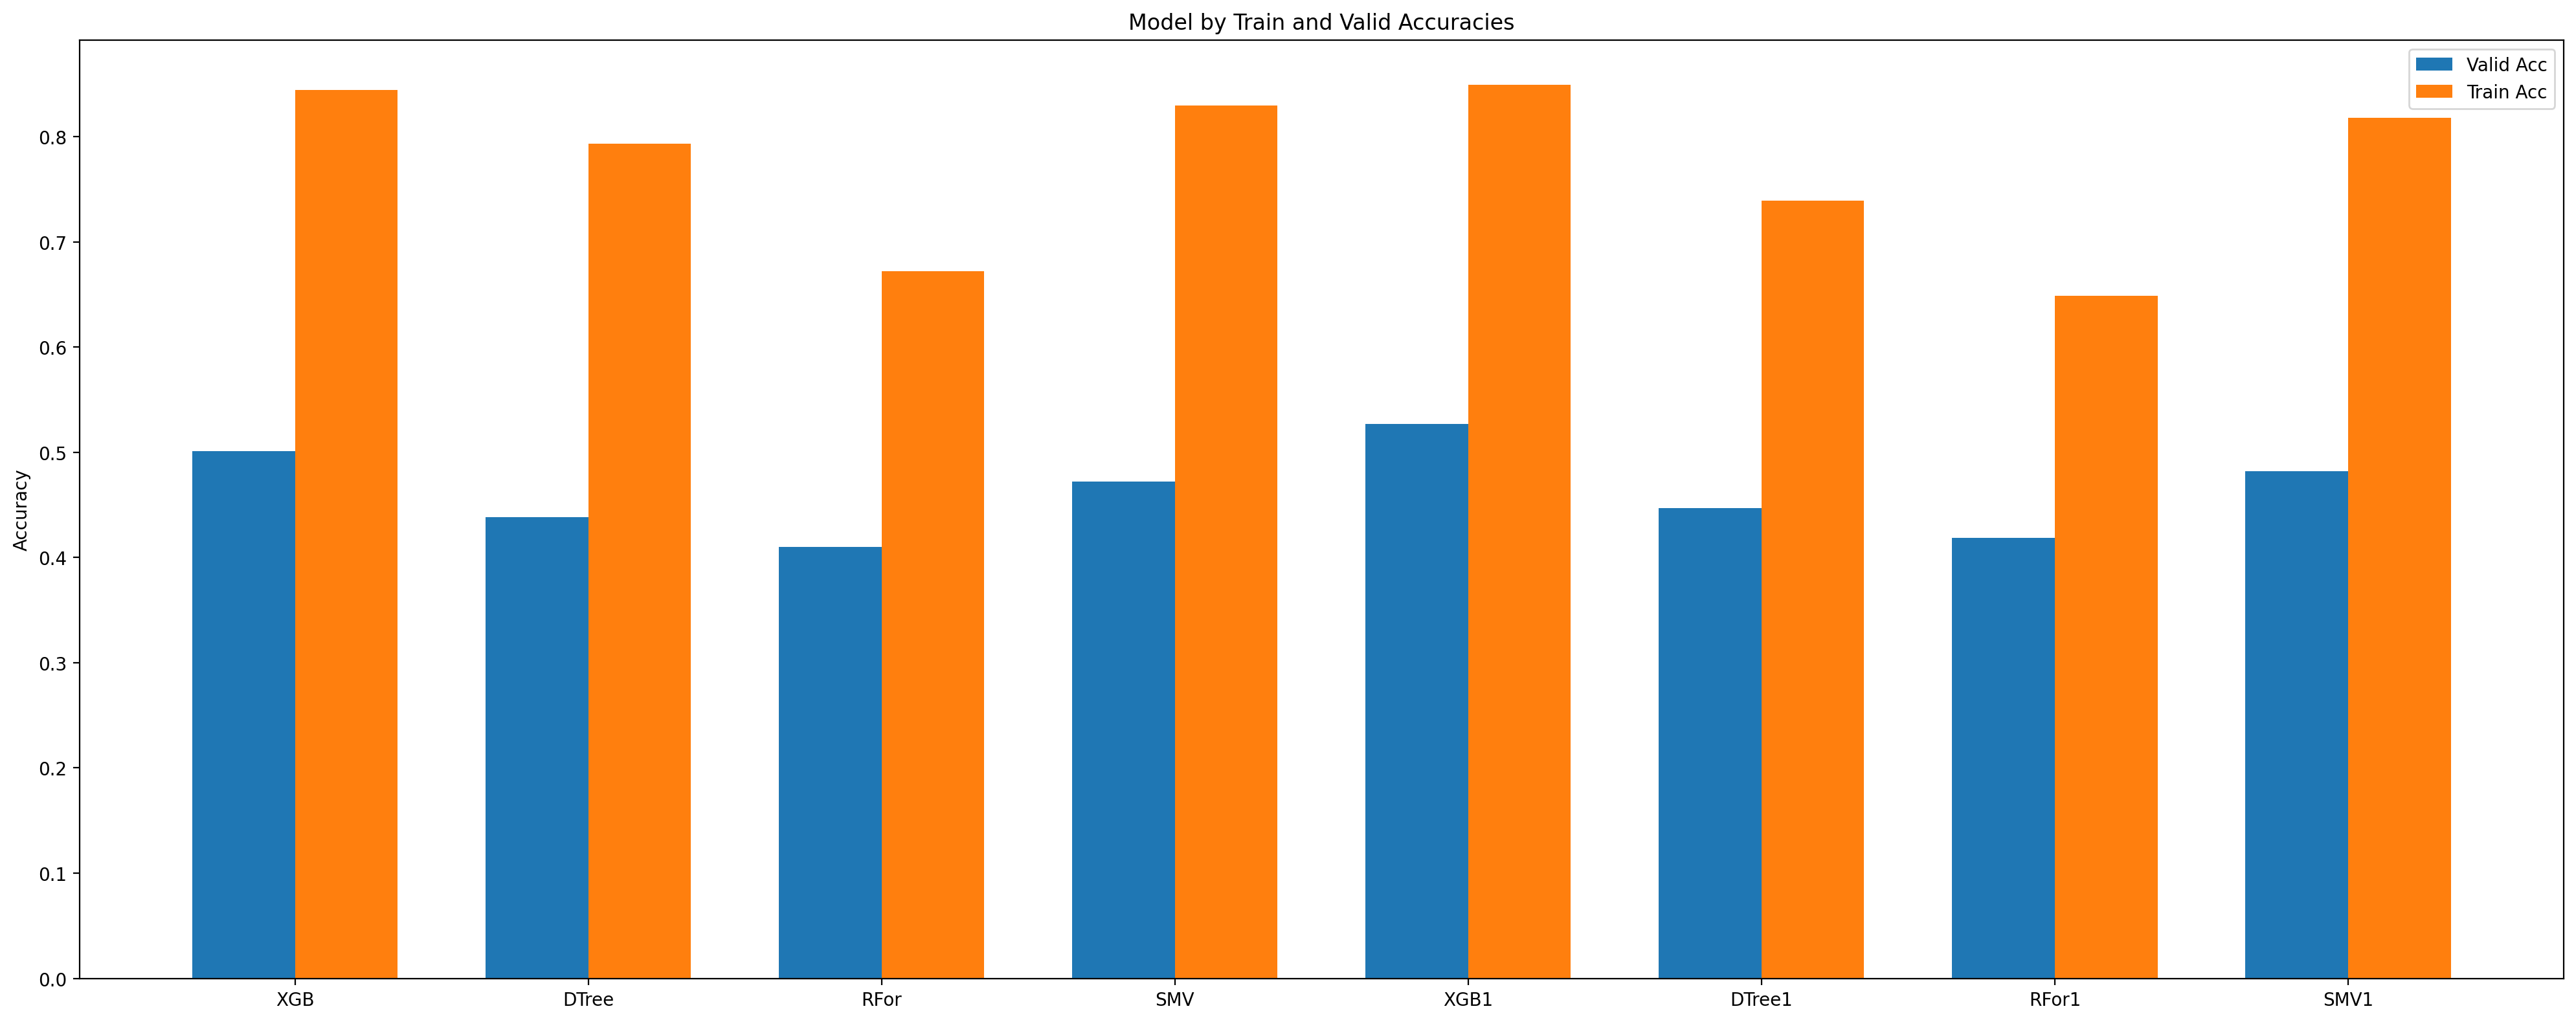

In [69]:
ModelsUsed = ['XGB', 'DTree', 'RFor', 'SMV', 'XGB1', 'DTree1', 'RFor1', 'SMV1',]
num_Models = np.arange(len(ModelsUsed))
width = 0.35  
fig, accCmp = plt.subplots()
accCmp.bar(num_Models - width/2, best_valid_acc_mo, width, label='Valid Acc')
accCmp.bar(num_Models + width/2, best_train_acc_mo, width, label='Train Acc')
accCmp.set_ylabel('Accuracy')
accCmp.set_title('Model by Train and Valid Accuracies')
accCmp.set_xticks(num_Models)
accCmp.set_xticklabels(ModelsUsed)
accCmp.legend()
fig.tight_layout()
plt.show()
#plots accuracies against model